Perbandingan Kinerja Algoritma Machine Learning (SVM, Naive Bayes, dan Decision Tree) dalam Klasifikasi Dataset Jamur


--- Tahap 1: Membaca Data ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-mount.
Berhasil memuat dataset dari: /content/drive/MyDrive/dataset/mushrooms.csv

Head Data:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b       

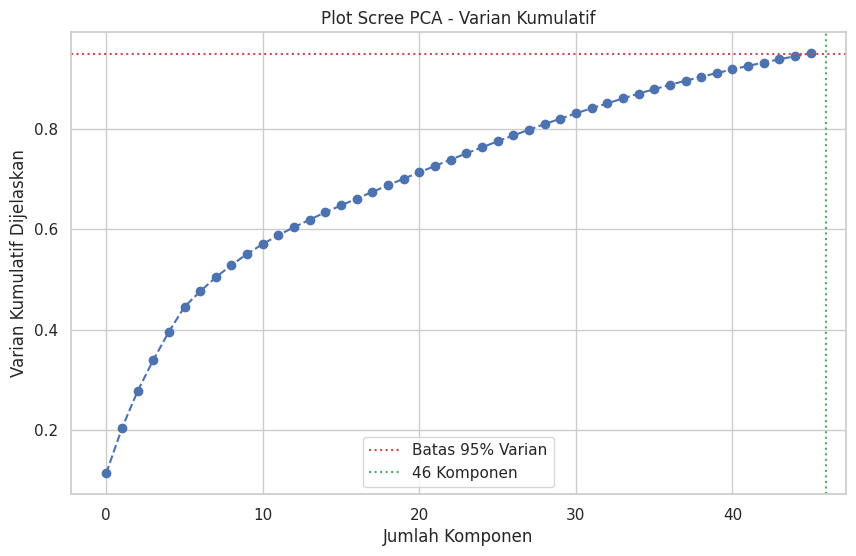


--- Tahap 6: Pembagian Data (Stratified Split 80:20) ---
Bentuk X_train: (6499, 46)
Bentuk X_test: (1625, 46)

Distribusi Kelas (Train Set):
       Proporsi
class          
0      0.517926
1      0.482074

Distribusi Kelas (Test Set):
       Proporsi
class          
0      0.518154
1      0.481846

--- Tahap 7: Penyeimbangan Kelas (SMOTE) ---
Distribusi Kelas (Train Set) SEBELUM SMOTE:
       Jumlah
class        
0        3366
1        3133

Distribusi Kelas (Train Set) SETELAH SMOTE:
       Jumlah
class        
1        3366
0        3366
Plot perbandingan SMOTE disimpan sebagai 'smote_comparison.png'


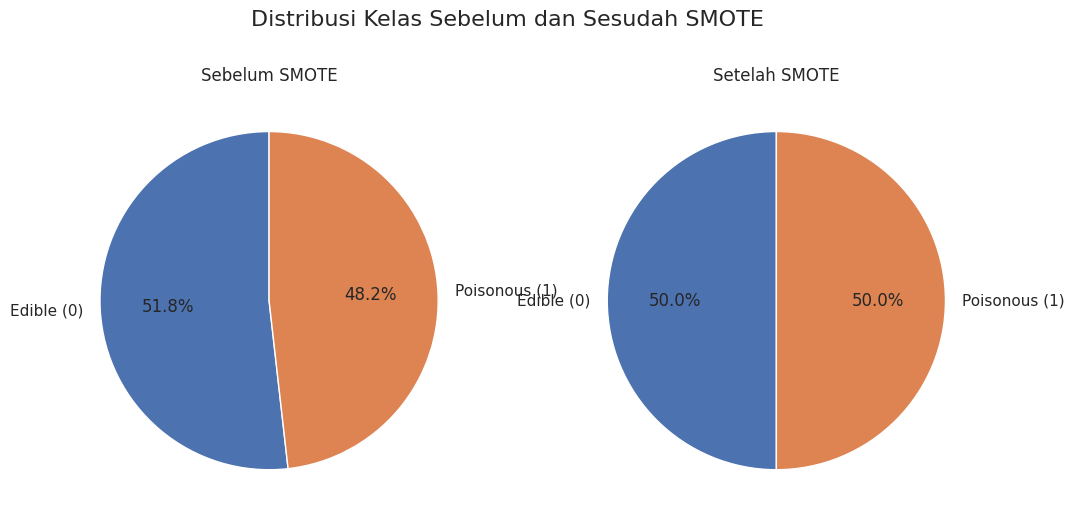


--- Tahap 8: Evaluasi Model dengan 10-Fold Cross-Validation ---
Melakukan 10-Fold CV untuk SVM...
Melakukan 10-Fold CV untuk Naive Bayes...
Melakukan 10-Fold CV untuk Decision Tree...

Rata-rata Hasil 10-Fold Cross-Validation (pada Data Train):
|               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:--------------|-----------:|------------:|---------:|-----------:|----------:|
| SVM           |     1.0000 |      1.0000 |   1.0000 |     1.0000 |    1.0000 |
| Naive Bayes   |     0.9150 |      0.8660 |   0.9822 |     0.9204 |    0.9922 |
| Decision Tree |     0.9963 |      0.9956 |   0.9970 |     0.9963 |    0.9963 |
Plot perbandingan CV disimpan sebagai 'model_comparison_boxplot.png'


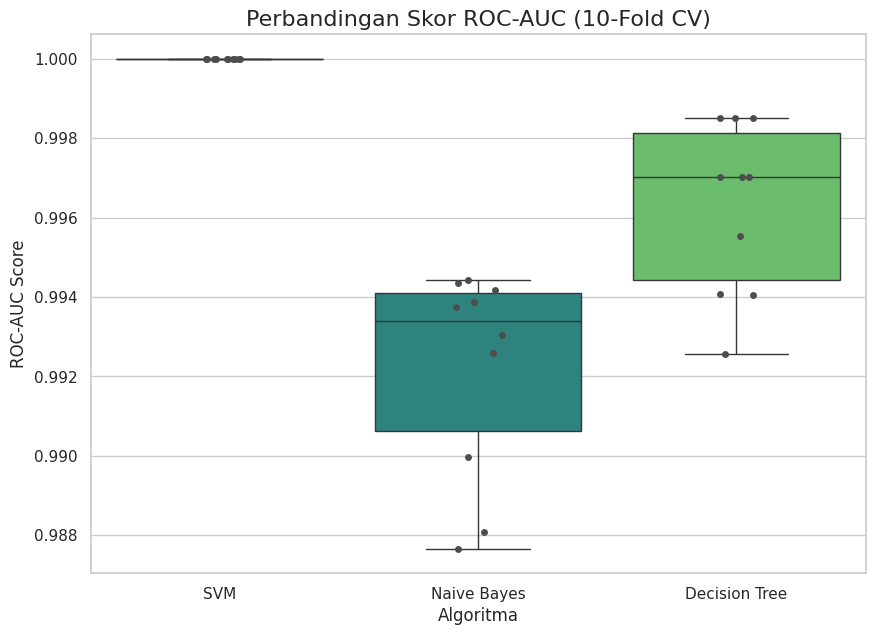


--- Tahap 9: Analisis Signifikansi Statistik (Uji T & Wilcoxon) ---
Membandingkan skor ROC-AUC per-fold (alpha = 0.05)
| Perbandingan                 |   T-test p-value |   Wilcoxon p-value | Signifikan (T-test)   | Signifikan (Wilcoxon)   |
|:-----------------------------|-----------------:|-------------------:|:----------------------|:------------------------|
| SVM vs Naive Bayes           |          0.00001 |            0.00195 | Ya                    | Ya                      |
| SVM vs Decision Tree         |          0.00037 |            0.00195 | Ya                    | Ya                      |
| Naive Bayes vs Decision Tree |          0.00759 |            0.02734 | Ya                    | Ya                      |

--- Tahap 10: Pelaporan Hasil Final (pada Test Set) ---
Melatih dan mengevaluasi SVM pada test set...
Melatih dan mengevaluasi Naive Bayes pada test set...
Melatih dan mengevaluasi Decision Tree pada test set...
Plot Kurva ROC Final disimpan sebagai 'final_roc_cur

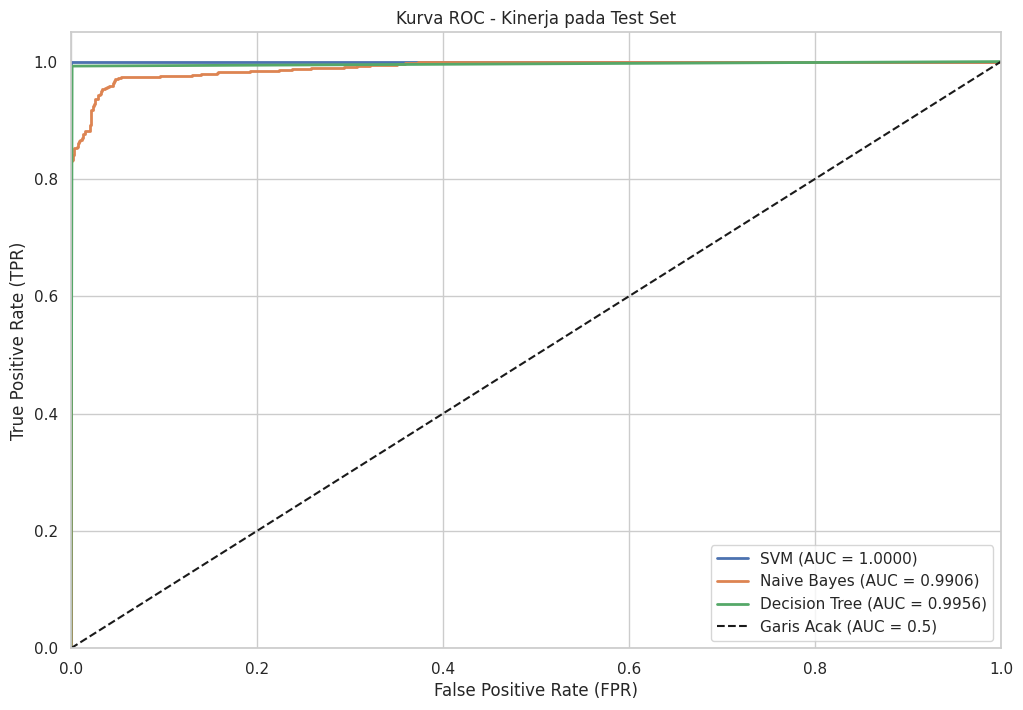


Hasil Akhir Metrik Evaluasi pada Test Set:
|               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:--------------|-----------:|------------:|---------:|-----------:|----------:|
| SVM           |     1.0000 |      1.0000 |   1.0000 |     1.0000 |    1.0000 |
| Naive Bayes   |     0.9126 |      0.8589 |   0.9796 |     0.9153 |    0.9906 |
| Decision Tree |     0.9957 |      0.9987 |   0.9923 |     0.9955 |    0.9956 |

Analisis Selesai.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve
)
from scipy.stats import ttest_rel, wilcoxon
import warnings

# Mengabaikan peringatan untuk tampilan yang lebih bersih
warnings.filterwarnings('ignore')

# Mengatur gaya plot
sns.set(style="whitegrid")

print("=======================================================================")
print("Perbandingan Kinerja Algoritma Machine Learning (SVM, Naive Bayes, dan Decision Tree) dalam Klasifikasi Dataset Jamur")
print("=======================================================================\n")

# -------------------------------------------------------------------
# Tahap 1: Mount Google Drive dan Baca File CSV
# -------------------------------------------------------------------
print("\n--- Tahap 1: Membaca Data ---")

# Mount Google Drive secara otomatis
try:
    drive.mount('/content/drive')
    print("Google Drive berhasil di-mount.")
except Exception as e:
    print(f"Error saat mount GDrive: {e}")

# Path file
file_path = '/content/drive/MyDrive/dataset/mushrooms.csv'

# Baca data
try:
    df = pd.read_csv(file_path)
    print(f"Berhasil memuat dataset dari: {file_path}")

    # Menampilkan 5 baris pertama (Tabel)
    print("\nHead Data:")
    print(df.head())

    # Menampilkan informasi dataset (Tabel)
    print("\nInfo Data:")
    df.info()

except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di path '{file_path}'.")
    print("Pastikan path file sudah benar dan file ada di GDrive Anda.")
    # Stop eksekusi jika file tidak ada
    # Dalam environment interaktif, ini akan menghentikan eksekusi sel
    raise

# -------------------------------------------------------------------
# Tahap 2: Pembersihan Data dan Kontrol Kualitas
# -------------------------------------------------------------------
print("\n--- Tahap 2: Pembersihan Data dan Kontrol Kualitas ---")

# Deteksi nilai kosong (seringkali '?' di dataset ini)
# Ganti '?' dengan NaN (Not a Number)
df.replace('?', np.nan, inplace=True)

# Menampilkan jumlah nilai kosong per kolom (Tabel)
print("\nJumlah Nilai Kosong (sebelum imputasi):")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].to_frame(name='Jumlah Kosong'))

# Deteksi dan hapus duplikasi
duplicate_count = df.duplicated().sum()
print(f"\nJumlah baris duplikat ditemukan: {duplicate_count}")
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Baris duplikat telah dihapus. Bentuk data baru: {df.shape}")

# Kontrol Kualitas Kategori (Sudah dilakukan dengan deteksi '?' di atas)
# Kita juga bisa memeriksa kategori unik jika ada yang tidak valid lainnya
# print("\nContoh Pengecekan Kategori Unik (stalk-root):")
# print(df['stalk-root'].unique())

# -------------------------------------------------------------------
# Tahap 3: Imputasi Nilai Hilang (Menggunakan Modus)
# -------------------------------------------------------------------
print("\n--- Tahap 3: Imputasi Nilai Hilang ---")

# Kolom yang memiliki nilai hilang
missing_cols = missing_values[missing_values > 0].index

if not missing_cols.empty:
    # Menggunakan SimpleImputer dengan strategi 'most_frequent' (modus)
    imputer = SimpleImputer(strategy='most_frequent')

    # Terapkan imputer ke kolom yang memiliki nilai hilang
    df[missing_cols] = imputer.fit_transform(df[missing_cols])

    print("Imputasi nilai hilang dengan modus telah selesai.")

    # Menampilkan tabel jumlah nilai kosong setelah imputasi (Tabel)
    print("\nJumlah Nilai Kosong (setelah imputasi):")
    print(df.isnull().sum().to_frame(name='Jumlah Kosong'))
else:
    print("Tidak ada nilai hilang yang perlu diimputasi.")

# -------------------------------------------------------------------
# Tahap 4: Deteksi dan Penyesuaian Kategori Langka
# -------------------------------------------------------------------
print("\n--- Tahap 4: Penyesuaian Kategori Langka ---")

print("Menganalisis dan menggabungkan kategori langka (kurang dari 1% data)...")

# Menyimpan jumlah kategori unik sebelum penyesuaian
unique_counts_before = {col: df[col].nunique() for col in df.columns if col != 'class'}

features = df.drop('class', axis=1).columns
total_rows = len(df)
min_freq = total_rows * 0.01  # Ambang batas 1%

for col in features:
    # Hitung frekuensi
    counts = df[col].value_counts()

    # Tentukan kategori langka
    rare_cats = counts[counts < min_freq].index

    if len(rare_cats) > 0:
        # Ganti kategori langka dengan 'Other'
        df[col] = df[col].replace(rare_cats, 'Other')

# Menyimpan jumlah kategori unik setelah penyesuaian
unique_counts_after = {col: df[col].nunique() for col in df.columns if col != 'class'}

# Menampilkan perbandingan jumlah kategori (Tabel)
counts_df = pd.DataFrame({
    'Unik Sebelum': unique_counts_before,
    'Unik Sesudah': unique_counts_after
})
counts_df['Perubahan'] = counts_df['Unik Sesudah'] - counts_df['Unik Sebelum']

print("\nPerbandingan Jumlah Kategori Unik (Sebelum vs Sesudah Penyesuaian):")
print(counts_df[counts_df['Perubahan'] != 0])

# -------------------------------------------------------------------
# Tahap 5: Pengkodean Fitur (OHE) dan Transformasi (PCA)
# -------------------------------------------------------------------
print("\n--- Tahap 5: Pengkodean Fitur dan Reduksi Dimensi ---")

# Pisahkan fitur (X) dan target (y)
X = df.drop('class', axis=1)
y = df['class']

# Pengkodean Target (y)
# edible (e) = 0, poisonous (p) = 1
y_encoded = y.map({'e': 0, 'p': 1})
print("\nDistribusi Kelas Target (y):")
print(y_encoded.value_counts().to_frame(name='Jumlah'))

# Pengkodean Fitur (X) menggunakan One-Hot Encoding
# drop_first=True untuk menghindari multikolinearitas
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)
print(f"\nBentuk data setelah One-Hot Encoding: {X_encoded.shape}")
print("Contoh data setelah OHE (Tabel):")
print(X_encoded.head())

# Reduksi Dimensi (PCA)
# 1. Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 2. Terapkan PCA untuk menangkap 95% varians
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nBentuk data setelah PCA (menangkap 95% varians): {X_pca.shape}")
print(f"Jumlah komponen PCA yang dipilih: {pca.n_components_}")

# Plot Varian Kumulatif (Gambar)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Varian Kumulatif Dijelaskan')
plt.title('Plot Scree PCA - Varian Kumulatif')
plt.axhline(y=0.95, color='r', linestyle=':', label='Batas 95% Varian')
plt.axvline(x=pca.n_components_, color='g', linestyle=':', label=f'{pca.n_components_} Komponen')
plt.legend()
plt.grid(True)
plt.savefig('pca_scree_plot.png')
print("Plot Scree PCA disimpan sebagai 'pca_scree_plot.png'")
plt.show()

# -------------------------------------------------------------------
# Tahap 6: Pembagian Data (Stratifikasi 80:20)
# -------------------------------------------------------------------
print("\n--- Tahap 6: Pembagian Data (Stratified Split 80:20) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # Menjaga keseimbangan kelas
)

print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")

# Menampilkan distribusi kelas di train dan test set (Tabel)
print("\nDistribusi Kelas (Train Set):")
print(y_train.value_counts(normalize=True).to_frame(name='Proporsi'))

print("\nDistribusi Kelas (Test Set):")
print(y_test.value_counts(normalize=True).to_frame(name='Proporsi'))

# -------------------------------------------------------------------
# Tahap 7: Penyeimbangan Kelas (SMOTE pada Data Train)
# -------------------------------------------------------------------
print("\n--- Tahap 7: Penyeimbangan Kelas (SMOTE) ---")

# Cek distribusi sebelum SMOTE
print("Distribusi Kelas (Train Set) SEBELUM SMOTE:")
print(y_train.value_counts().to_frame(name='Jumlah'))

# Terapkan SMOTE hanya pada data training
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nDistribusi Kelas (Train Set) SETELAH SMOTE:")
print(y_train_res.value_counts().to_frame(name='Jumlah'))

# Visualisasi perbandingan (Gambar)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distribusi Kelas Sebelum dan Sesudah SMOTE', fontsize=16)

y_train.value_counts().plot.pie(
    autopct='%1.1f%%', ax=ax1,
    title='Sebelum SMOTE',
    labels=['Edible (0)', 'Poisonous (1)'],
    startangle=90
)
ax1.set_ylabel('')

y_train_res.value_counts().plot.pie(
    autopct='%1.1f%%', ax=ax2,
    title='Setelah SMOTE',
    labels=['Edible (0)', 'Poisonous (1)'],
    startangle=90
)
ax2.set_ylabel('')

plt.savefig('smote_comparison.png')
print("Plot perbandingan SMOTE disimpan sebagai 'smote_comparison.png'")
plt.show()

# -------------------------------------------------------------------
# Tahap 8: Evaluasi Performa Model (Cross-Validation 10-Fold)
# -------------------------------------------------------------------
print("\n--- Tahap 8: Evaluasi Model dengan 10-Fold Cross-Validation ---")

# Inisialisasi model
# probability=True diperlukan untuk ROC-AUC pada SVM
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Tentukan K-Fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Tentukan metrik
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results_data = {}
all_auc_scores = {}

# Lakukan cross-validation
for model_name, model in models.items():
    print(f"Melakukan 10-Fold CV untuk {model_name}...")
    # Gunakan data train yang sudah di-resample (X_train_res, y_train_res)
    cv_results = cross_validate(
        model,
        X_train_res,
        y_train_res,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1 # Gunakan semua core
    )
    cv_results_data[model_name] = cv_results
    all_auc_scores[model_name] = cv_results['test_roc_auc']

# Buat tabel rata-rata hasil CV (Tabel)
mean_scores = {}
for name, results in cv_results_data.items():
    mean_scores[name] = {
        'Accuracy': np.mean(results['test_accuracy']),
        'Precision': np.mean(results['test_precision']),
        'Recall': np.mean(results['test_recall']),
        'F1-Score': np.mean(results['test_f1']),
        'ROC-AUC': np.mean(results['test_roc_auc'])
    }

results_df = pd.DataFrame(mean_scores).T
print("\nRata-rata Hasil 10-Fold Cross-Validation (pada Data Train):")
print(results_df.to_markdown(floatfmt=".4f"))

# Buat boxplot perbandingan ROC-AUC (Gambar)
auc_df = pd.DataFrame(all_auc_scores)
plt.figure(figsize=(10, 7))
sns.boxplot(data=auc_df, palette='viridis')
sns.stripplot(data=auc_df, color=".3", size=5, jitter=True)
plt.title('Perbandingan Skor ROC-AUC (10-Fold CV)', fontsize=16)
plt.ylabel('ROC-AUC Score')
plt.xlabel('Algoritma')
plt.savefig('model_comparison_boxplot.png')
print("Plot perbandingan CV disimpan sebagai 'model_comparison_boxplot.png'")
plt.show()

# -------------------------------------------------------------------
# Tahap 9: Analisis Signifikansi Statistik
# -------------------------------------------------------------------
print("\n--- Tahap 9: Analisis Signifikansi Statistik (Uji T & Wilcoxon) ---")
print("Membandingkan skor ROC-AUC per-fold (alpha = 0.05)")

# Ambil skor ROC-AUC dari hasil CV
svm_scores = all_auc_scores['SVM']
nb_scores = all_auc_scores['Naive Bayes']
dt_scores = all_auc_scores['Decision Tree']

# Buat perbandingan
comparisons = [
    ('SVM', 'Naive Bayes', svm_scores, nb_scores),
    ('SVM', 'Decision Tree', svm_scores, dt_scores),
    ('Naive Bayes', 'Decision Tree', nb_scores, dt_scores)
]

stats_results = []

alpha = 0.05

for name1, name2, scores1, scores2 in comparisons:
    # Paired t-test
    t_stat, t_p = ttest_rel(scores1, scores2)

    # Wilcoxon signed-rank test
    # Perlu penanganan jika skor identik (zero_method='zsplit')
    try:
        w_stat, w_p = wilcoxon(scores1, scores2, zero_method='zsplit', correction=True)
    except ValueError:
        # Terjadi jika semua perbedaan adalah nol
        w_stat, w_p = (0, 1.0)

    stats_results.append({
        'Perbandingan': f'{name1} vs {name2}',
        'T-test p-value': t_p,
        'Wilcoxon p-value': w_p,
        'Signifikan (T-test)': 'Ya' if t_p < alpha else 'Tidak',
        'Signifikan (Wilcoxon)': 'Ya' if w_p < alpha else 'Tidak'
    })

# Tampilkan hasil tes statistik (Tabel)
stats_df = pd.DataFrame(stats_results)
print(stats_df.to_markdown(index=False, floatfmt=".5f"))

# -------------------------------------------------------------------
# Tahap 10: Pelaporan Hasil (Evaluasi Final pada Test Set)
# -------------------------------------------------------------------
print("\n--- Tahap 10: Pelaporan Hasil Final (pada Test Set) ---")

final_reports = {}
plt.figure(figsize=(12, 8))

# Latih model pada SEMUA data train yang sudah di-resample
# dan evaluasi pada data test yang belum pernah dilihat
for model_name, model in models.items():
    print(f"Melatih dan mengevaluasi {model_name} pada test set...")

    # Latih model
    model.fit(X_train_res, y_train_res)

    # Prediksi
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probabilitas kelas positif (1)

    # Simpan metrik
    final_reports[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    # Plot ROC Curve (Gambar)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = final_reports[model_name]['ROC-AUC']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', lw=2)

# Konfigurasi plot ROC
plt.plot([0, 1], [0, 1], 'k--', label='Garis Acak (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Kurva ROC - Kinerja pada Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('final_roc_curve.png')
print("Plot Kurva ROC Final disimpan sebagai 'final_roc_curve.png'")
plt.show()

# Tampilkan tabel laporan akhir (Tabel)
final_report_df = pd.DataFrame(final_reports).T
print("\nHasil Akhir Metrik Evaluasi pada Test Set:")
print(final_report_df.to_markdown(floatfmt=".4f"))

print("\n=======================================================================")
print("Analisis Selesai.")
print("=======================================================================")